# Detecting Pneumonia by Using CNNs

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
from tensorflow import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from tensorflow.keras import models
from tensorflow.keras import layers

from tensorflow.keras import regularizers

from tensorflow.keras.models import load_model

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [3]:
random.set_seed(24)

In [4]:
# File directory
train_dir = 'chest_xray/train'
test_dir = 'chest_xray/test'
val_dir = 'chest_xray/val'

In [5]:
# Get all the train data (5216) in the directory, scale, and reshape
train_generator = ImageDataGenerator(rescale=1./255)\
                  .flow_from_directory(train_dir, target_size=(128,128), batch_size=5216)

# Get all the test data (624) in the directory, scale, and reshape
test_generator = ImageDataGenerator(rescale=1./255)\
                 .flow_from_directory(test_dir, target_size=(128,128), batch_size=624) 

# Get all the validation data (16) in the directory, scale, and reshape
val_generator = ImageDataGenerator(rescale=1./255)\
                .flow_from_directory(val_dir, target_size=(128,128), batch_size=16) 

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [6]:
# create the data sets
# next - retrieve the next item from iterator
X_train, train_labels = next(train_generator)
X_test, test_labels = next(test_generator)
X_val, val_labels = next(val_generator)

In [7]:
# Check the shape
print ("train_images shape: " + str(X_train.shape))
print ("train_labels shape: " + str(train_labels.shape))

print ("test_images shape: " + str(X_test.shape))
print ("test_labels shape: " + str(test_labels.shape))

print ("val_images shape: " + str(X_val.shape))
print ("val_labels shape: " + str(val_labels.shape))

train_images shape: (5216, 128, 128, 3)
train_labels shape: (5216, 2)
test_images shape: (624, 128, 128, 3)
test_labels shape: (624, 2)
val_images shape: (16, 128, 128, 3)
val_labels shape: (16, 2)


In [8]:
y_train = np.reshape(train_labels[:,0], (5216,1))
y_test = np.reshape(test_labels[:,0], (624,1))
y_val = np.reshape(val_labels[:,0], (16,1))

print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(5216, 1)
(624, 1)
(16, 1)


In [9]:
def visualize_training_results(history):
    '''
    From https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
    
    Input: keras history object (output from trained model)
    '''
    fig, (ax1, ax2) = plt.subplots(2, sharex=True)
    fig.suptitle('Model Results')

    # summarize history for accuracy
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_ylabel('Accuracy')
    ax1.legend(['train', 'test'], loc='upper left')
    
    # summarize history for loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_ylabel('Loss')
    ax2.legend(['train', 'test'], loc='upper left')
    
    plt.xlabel('Epoch')
    plt.show()

In [10]:
def model_evaluation(model):
    result_train = model.evaluate(X_train, y_train)
    print(f'Training Loss:{result_train[0]:.4}')
    print(f'Training Accuracy:{result_train[1]:.4}')
    
    result_val = model.evaluate(X_val, y_val)
    print(f'Val Loss:{result_val[0]:.4}')
    print(f'Val Accuracy:{result_val[1]:.4}')

## CNN Baseline Model
- 3 block

In [11]:
base_model = models.Sequential()
base_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128,128,3)))
base_model.add(layers.MaxPooling2D((2, 2)))

base_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
base_model.add(layers.MaxPooling2D((2, 2)))

base_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
base_model.add(layers.MaxPooling2D((2, 2)))

base_model.add(layers.Flatten())
base_model.add(layers.Dense(128, activation='relu'))
base_model.add(layers.Dense(1, activation='sigmoid'))

base_model.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

In [12]:
base_history = base_model.fit(X_train, y_train,
                              epochs=50,
                              batch_size=32,
                              validation_data=(X_test, y_test))

Epoch 1/50
163/163 [==============================] - 43s 260ms/step - loss: 0.4430 - accuracy: 0.7968 - val_loss: 0.4689 - val_accuracy: 0.8013
Epoch 2/50
163/163 [==============================] - 41s 254ms/step - loss: 0.1252 - accuracy: 0.9530 - val_loss: 1.1855 - val_accuracy: 0.7276
Epoch 3/50
163/163 [==============================] - 41s 254ms/step - loss: 0.0680 - accuracy: 0.9765 - val_loss: 0.8361 - val_accuracy: 0.7596
Epoch 4/50
163/163 [==============================] - 42s 256ms/step - loss: 0.0622 - accuracy: 0.9807 - val_loss: 0.8057 - val_accuracy: 0.7772
Epoch 5/50
163/163 [==============================] - 42s 257ms/step - loss: 0.0582 - accuracy: 0.9804 - val_loss: 0.8775 - val_accuracy: 0.7724
Epoch 6/50
163/163 [==============================] - 42s 258ms/step - loss: 0.0506 - accuracy: 0.9828 - val_loss: 1.0743 - val_accuracy: 0.7420
Epoch 7/50
163/163 [==============================] - 42s 259ms/step - loss: 0.0376 - accuracy: 0.9871 - val_loss: 1.0228 - val_ac

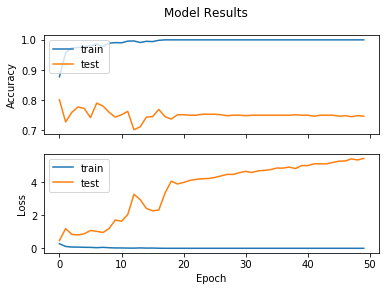

In [13]:
visualize_training_results(base_history)

In [14]:
base_model.save('base_model.h5')

In [15]:
base = load_model('base_model.h5')
model_evaluation(base)

163/163 [==============================] - 10s 62ms/step - loss: 1.8565e-06 - accuracy: 1.0000
Training Loss:1.857e-06
Training Accuracy:1.0
1/1 [==============================] - 0s 125ms/step - loss: 0.4588 - accuracy: 0.9375
Val Loss:0.4588
Val Accuracy:0.9375


>**Comment:** *Baseline Model*
- The baseline model took about 40 minutes to run
- The train accuracy (1.0) is higher than val accuracy (0.9375) which indicates that the baseline model is overfit
- The visualization shows test accuracy did not show too much improvements after 20 epochs while the test loss shows an increase trend
- Early stoppling can be applied for iteration model tunning to prevent overfit and saving time

## Dropout 20
- Add (20%) dropout layers and earlystopping 

In [16]:
dropout_20 = models.Sequential()
dropout_20.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128,128,3)))
dropout_20.add(layers.MaxPooling2D((2, 2)))
dropout_20.add(layers.Dropout(0.2))

dropout_20.add(layers.Conv2D(64, (3, 3), activation='relu'))
dropout_20.add(layers.MaxPooling2D((2, 2)))
dropout_20.add(layers.Dropout(0.2))

dropout_20.add(layers.Conv2D(128, (3, 3), activation='relu'))
dropout_20.add(layers.MaxPooling2D((2, 2)))
dropout_20.add(layers.Dropout(0.2))

dropout_20.add(layers.Flatten())
dropout_20.add(layers.Dense(128, activation='relu'))
dropout_20.add(layers.Dense(1, activation='sigmoid'))

dropout_20.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

In [17]:
es_dp_20 = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=6),
         ModelCheckpoint(filepath='best_dropout_20.h5', monitor='val_accuracy', 
                         mode='max', verbose=1, save_best_only=True)]

In [18]:
dropout_20_history = dropout_20.fit(X_train, y_train,
                                epochs=50,
                                batch_size=32,
                                callbacks=es_dp_20,
                                validation_data=(X_test, y_test))

Epoch 1/50
163/163 [==============================] - 49s 295ms/step - loss: 0.5665 - accuracy: 0.7648 - val_loss: 0.7180 - val_accuracy: 0.7388

Epoch 00001: val_accuracy improved from -inf to 0.73878, saving model to best_dropout_20.h5
Epoch 2/50
163/163 [==============================] - 47s 291ms/step - loss: 0.1443 - accuracy: 0.9426 - val_loss: 0.8041 - val_accuracy: 0.7564

Epoch 00002: val_accuracy improved from 0.73878 to 0.75641, saving model to best_dropout_20.h5
Epoch 3/50
163/163 [==============================] - 49s 301ms/step - loss: 0.0971 - accuracy: 0.9613 - val_loss: 0.7375 - val_accuracy: 0.7756

Epoch 00003: val_accuracy improved from 0.75641 to 0.77564, saving model to best_dropout_20.h5
Epoch 4/50
163/163 [==============================] - 48s 293ms/step - loss: 0.0764 - accuracy: 0.9723 - val_loss: 0.5995 - val_accuracy: 0.7853

Epoch 00004: val_accuracy improved from 0.77564 to 0.78526, saving model to best_dropout_20.h5
Epoch 5/50
163/163 [===================

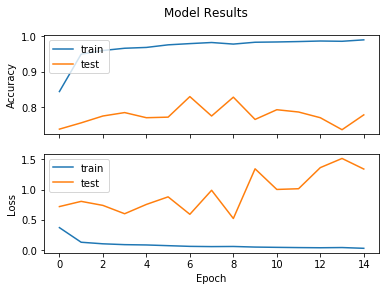

In [19]:
visualize_training_results(dropout_20_history)

In [20]:
dp20 = load_model('best_dropout_20.h5')
model_evaluation(dp20)

163/163 [==============================] - 11s 66ms/step - loss: 0.0766 - accuracy: 0.9712
Training Loss:0.07663
Training Accuracy:0.9712
1/1 [==============================] - 0s 129ms/step - loss: 0.0855 - accuracy: 1.0000
Val Loss:0.08555
Val Accuracy:1.0


## Dropout 50
- Add (50%) dropout layer and earlystopping

In [21]:
dropout_50 = models.Sequential()
dropout_50.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128,128,3)))
dropout_50.add(layers.MaxPooling2D((2, 2)))
dropout_50.add(layers.Dropout(0.5))

dropout_50.add(layers.Conv2D(64, (3, 3), activation='relu'))
dropout_50.add(layers.MaxPooling2D((2, 2)))
dropout_50.add(layers.Dropout(0.5))

dropout_50.add(layers.Conv2D(128, (3, 3), activation='relu'))
dropout_50.add(layers.MaxPooling2D((2, 2)))
dropout_50.add(layers.Dropout(0.5))

dropout_50.add(layers.Flatten())
dropout_50.add(layers.Dense(128, activation='relu'))
dropout_50.add(layers.Dense(1, activation='sigmoid'))

dropout_50.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

In [22]:
es_dp_50 = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=6),
            ModelCheckpoint(filepath='best_dropout_50.h5', monitor='val_accuracy', 
                            mode='max', verbose=1, save_best_only=True)]

In [23]:
dropout_50_history = dropout_50.fit(X_train, y_train,
                                epochs=50,
                                batch_size=32,
                                callbacks=es_dp_50,
                                validation_data=(X_test, y_test))

Epoch 1/50
163/163 [==============================] - 49s 295ms/step - loss: 0.6889 - accuracy: 0.7211 - val_loss: 0.4302 - val_accuracy: 0.8077

Epoch 00001: val_accuracy improved from -inf to 0.80769, saving model to best_dropout_50.h5
Epoch 2/50
163/163 [==============================] - 47s 290ms/step - loss: 0.2108 - accuracy: 0.9120 - val_loss: 0.6183 - val_accuracy: 0.7484

Epoch 00002: val_accuracy did not improve from 0.80769
Epoch 3/50
163/163 [==============================] - 48s 292ms/step - loss: 0.1517 - accuracy: 0.9385 - val_loss: 0.5473 - val_accuracy: 0.7740

Epoch 00003: val_accuracy did not improve from 0.80769
Epoch 4/50
163/163 [==============================] - 48s 297ms/step - loss: 0.1238 - accuracy: 0.9581 - val_loss: 0.7113 - val_accuracy: 0.7163

Epoch 00004: val_accuracy did not improve from 0.80769
Epoch 5/50
163/163 [==============================] - 50s 306ms/step - loss: 0.1278 - accuracy: 0.9532 - val_loss: 0.5873 - val_accuracy: 0.7484

Epoch 00005: 

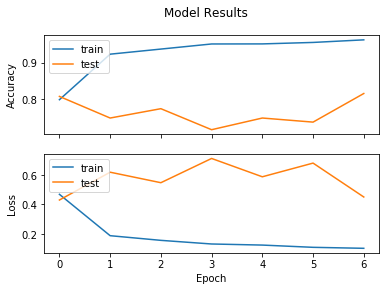

In [24]:
visualize_training_results(dropout_50_history)

In [25]:
dp50 = load_model('best_dropout_50.h5')
model_evaluation(dp50)

163/163 [==============================] - 11s 70ms/step - loss: 0.1172 - accuracy: 0.9689
Training Loss:0.1172
Training Accuracy:0.9689
1/1 [==============================] - 0s 131ms/step - loss: 0.2597 - accuracy: 1.0000
Val Loss:0.2597
Val Accuracy:1.0


## Dropout 35

In [40]:
dropout_35 = models.Sequential()
dropout_35.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128,128,3)))
dropout_35.add(layers.MaxPooling2D((2, 2)))
dropout_35.add(layers.Dropout(0.25))

dropout_35.add(layers.Conv2D(64, (3, 3), activation='relu'))
dropout_35.add(layers.MaxPooling2D((2, 2)))
dropout_25.add(layers.Dropout(0.25))

dropout_35.add(layers.Conv2D(128, (3, 3), activation='relu'))
dropout_35.add(layers.MaxPooling2D((2, 2)))
dropout_35.add(layers.Dropout(0.25))

dropout_35.add(layers.Flatten())
dropout_35.add(layers.Dense(128, activation='relu'))
dropout_35.add(layers.Dense(1, activation='sigmoid'))

dropout_35.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

In [42]:
es_dp_35 = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=6),
            ModelCheckpoint(filepath='best_dropout_35.h5', monitor='val_accuracy', 
                            mode='max', verbose=1, save_best_only=True)]

In [43]:
dropout_35_history = dropout_35.fit(X_train, y_train,
                                epochs=50,
                                batch_size=32,
                                callbacks=es_dp_35,
                                validation_data=(X_test, y_test))

Epoch 1/50
163/163 [==============================] - 48s 291ms/step - loss: 0.5277 - accuracy: 0.7511 - val_loss: 0.6833 - val_accuracy: 0.7644

Epoch 00001: val_accuracy improved from -inf to 0.76442, saving model to best_dropout_35.h5
Epoch 2/50
163/163 [==============================] - 47s 289ms/step - loss: 0.1234 - accuracy: 0.9510 - val_loss: 0.7531 - val_accuracy: 0.7644

Epoch 00002: val_accuracy did not improve from 0.76442
Epoch 3/50
163/163 [==============================] - 46s 284ms/step - loss: 0.1117 - accuracy: 0.9590 - val_loss: 0.8451 - val_accuracy: 0.7628

Epoch 00003: val_accuracy did not improve from 0.76442
Epoch 4/50
163/163 [==============================] - 46s 280ms/step - loss: 0.0742 - accuracy: 0.9708 - val_loss: 1.0304 - val_accuracy: 0.7356

Epoch 00004: val_accuracy did not improve from 0.76442
Epoch 5/50
163/163 [==============================] - 46s 280ms/step - loss: 0.0729 - accuracy: 0.9714 - val_loss: 0.9976 - val_accuracy: 0.7436

Epoch 00005: 

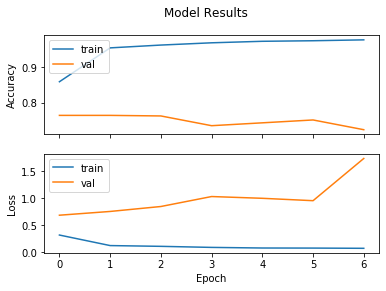

In [44]:
visualize_training_results(dropout_35_history)

In [45]:
dp35 = load_model('best_dropout_35.h5')
model_evaluation(dp35)

163/163 [==============================] - 11s 65ms/step - loss: 0.0998 - accuracy: 0.9615
[0.09980279207229614, 0.9614647030830383]
1/1 [==============================] - 0s 130ms/step - loss: 0.6258 - accuracy: 0.6250
[0.6258485317230225, 0.625]


## L2 Regularizer

In [12]:
L2_reg = models.Sequential()
L2_reg.add(layers.Conv2D(32, (3, 3), kernel_regularizer=regularizers.l2(0.005), activation='relu', input_shape=(128,128,3)))
L2_reg.add(layers.MaxPooling2D((2, 2)))

L2_reg.add(layers.Conv2D(64, (3, 3), kernel_regularizer=regularizers.l2(0.005), activation='relu'))
L2_reg.add(layers.MaxPooling2D((2, 2)))

L2_reg.add(layers.Conv2D(128, (3, 3), kernel_regularizer=regularizers.l2(0.005), activation='relu'))
L2_reg.add(layers.MaxPooling2D((2, 2)))

L2_reg.add(layers.Flatten())
L2_reg.add(layers.Dense(128, activation='relu'))
L2_reg.add(layers.Dense(1, activation='sigmoid'))

L2_reg.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=['accuracy'])

In [13]:
es_L2 = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=6),
         ModelCheckpoint(filepath='best_L2.h5', monitor='val_accuracy', 
                         mode='max', verbose=1, save_best_only=True)]

In [14]:
L2_reg_history = L2_reg.fit(X_train, y_train,
                                epochs=50,
                                batch_size=32,
                                callbacks=es_L2,
                                validation_data=(X_test, y_test))

Epoch 1/50
163/163 [==============================] - 43s 263ms/step - loss: 0.9341 - accuracy: 0.7123 - val_loss: 0.6311 - val_accuracy: 0.6635

Epoch 00001: val_accuracy improved from -inf to 0.66346, saving model to best_l2.h5
Epoch 2/50
163/163 [==============================] - 41s 253ms/step - loss: 0.3552 - accuracy: 0.9253 - val_loss: 0.7534 - val_accuracy: 0.7372

Epoch 00002: val_accuracy improved from 0.66346 to 0.73718, saving model to best_l2.h5
Epoch 3/50
163/163 [==============================] - 41s 249ms/step - loss: 0.2808 - accuracy: 0.9505 - val_loss: 0.7813 - val_accuracy: 0.7660

Epoch 00003: val_accuracy improved from 0.73718 to 0.76603, saving model to best_l2.h5
Epoch 4/50
163/163 [==============================] - 41s 252ms/step - loss: 0.2459 - accuracy: 0.9600 - val_loss: 0.8803 - val_accuracy: 0.7244

Epoch 00004: val_accuracy did not improve from 0.76603
Epoch 5/50
163/163 [==============================] - 41s 251ms/step - loss: 0.2126 - accuracy: 0.9684 

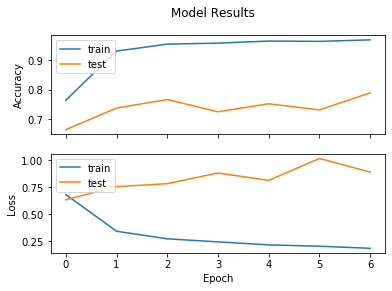

In [15]:
visualize_training_results(L2_reg_history)

In [16]:
L2 = load_model('best_L2.h5')
model_evaluation(L2)

163/163 [==============================] - 11s 68ms/step - loss: 0.1667 - accuracy: 0.9753
Training Loss:0.1667
Training Accuracy:0.9753
1/1 [==============================] - 0s 139ms/step - loss: 0.3551 - accuracy: 0.8750
Val Loss:0.3551
Val Accuracy:0.875


## L2_01

In [30]:
L2_01 = models.Sequential()
L2_01.add(layers.Conv2D(32, (3, 3), kernel_regularizer=regularizers.l2(0.01), activation='relu', input_shape=(128,128,3)))
L2_01.add(layers.MaxPooling2D((2, 2)))

L2_01.add(layers.Conv2D(64, (3, 3), kernel_regularizer=regularizers.l2(0.01), activation='relu'))
L2_01.add(layers.MaxPooling2D((2, 2)))

L2_01.add(layers.Conv2D(128, (3, 3), kernel_regularizer=regularizers.l2(0.01), activation='relu'))
L2_01.add(layers.MaxPooling2D((2, 2)))

L2_01.add(layers.Flatten())
L2_01.add(layers.Dense(128, activation='relu'))
L2_01.add(layers.Dense(1, activation='sigmoid'))

L2_01.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

In [31]:
es_L2_01 = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=6),
                    ModelCheckpoint(filepath='best_L2_01.h5', monitor='val_accuracy', 
                                    mode='max', verbose=1, save_best_only=True)]

In [32]:
L2_01_history = L2_01.fit(X_train, y_train,
                                epochs=50,
                                batch_size=32,
                                callbacks=es_L2_01,
                                validation_data=(X_test, y_test))

Epoch 1/50
163/163 [==============================] - 43s 263ms/step - loss: 1.0809 - accuracy: 0.7900 - val_loss: 0.6650 - val_accuracy: 0.7804

Epoch 00001: val_accuracy improved from -inf to 0.78045, saving model to best_l2_01.h5
Epoch 2/50
163/163 [==============================] - 43s 261ms/step - loss: 0.2472 - accuracy: 0.9575 - val_loss: 1.0576 - val_accuracy: 0.7292

Epoch 00002: val_accuracy did not improve from 0.78045
Epoch 3/50
163/163 [==============================] - 43s 261ms/step - loss: 0.1939 - accuracy: 0.9598 - val_loss: 0.8674 - val_accuracy: 0.7532

Epoch 00003: val_accuracy did not improve from 0.78045
Epoch 4/50
163/163 [==============================] - 44s 267ms/step - loss: 0.1653 - accuracy: 0.9662 - val_loss: 0.5735 - val_accuracy: 0.8125

Epoch 00004: val_accuracy improved from 0.78045 to 0.81250, saving model to best_l2_01.h5
Epoch 5/50
163/163 [==============================] - 42s 260ms/step - loss: 0.1431 - accuracy: 0.9698 - val_loss: 0.8243 - val_a

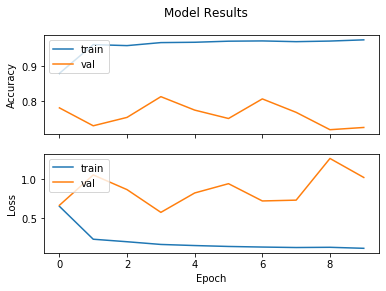

In [33]:
visualize_training_results(L2_01_history)

In [34]:
L201 = load_model('best_L2_01.h5')
model_evaluation(L201)

163/163 [==============================] - 11s 65ms/step - loss: 0.1540 - accuracy: 0.9645
[0.15400975942611694, 0.964532196521759]
1/1 [==============================] - 0s 133ms/step - loss: 0.3600 - accuracy: 0.8750
[0.36000385880470276, 0.875]


## L1 Regularizer

In [35]:
L1_reg = models.Sequential()
L1_reg.add(layers.Conv2D(32, (3, 3), kernel_regularizer=regularizers.l1(0.005), activation='relu', input_shape=(128,128,3)))
L1_reg.add(layers.MaxPooling2D((2, 2)))

L1_reg.add(layers.Conv2D(64, (3, 3), kernel_regularizer=regularizers.l1(0.005), activation='relu'))
L1_reg.add(layers.MaxPooling2D((2, 2)))

L1_reg.add(layers.Conv2D(128, (3, 3), kernel_regularizer=regularizers.l1(0.005), activation='relu'))
L1_reg.add(layers.MaxPooling2D((2, 2)))

L1_reg.add(layers.Flatten())
L1_reg.add(layers.Dense(128, activation='relu'))
L1_reg.add(layers.Dense(1, activation='sigmoid'))

L1_reg.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=['accuracy'])

In [36]:
es_L1 = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=6),
         ModelCheckpoint(filepath='best_L1.h5', monitor='val_accuracy', 
                         mode='max', verbose=1, save_best_only=True)]

In [37]:
L1_reg_history = L1_reg.fit(X_train, y_train,
                            epochs=50,
                            batch_size=32,
                            callbacks=es_L1,
                            validation_data=(X_test, y_test))

Epoch 1/50
163/163 [==============================] - 42s 257ms/step - loss: 7.1895 - accuracy: 0.7974 - val_loss: 0.8748 - val_accuracy: 0.7933

Epoch 00001: val_accuracy improved from -inf to 0.79327, saving model to best_l1.h5
Epoch 2/50
163/163 [==============================] - 42s 260ms/step - loss: 0.4764 - accuracy: 0.9433 - val_loss: 1.1042 - val_accuracy: 0.7324

Epoch 00002: val_accuracy did not improve from 0.79327
Epoch 3/50
163/163 [==============================] - 42s 259ms/step - loss: 0.2929 - accuracy: 0.9567 - val_loss: 0.6715 - val_accuracy: 0.8061

Epoch 00003: val_accuracy improved from 0.79327 to 0.80609, saving model to best_l1.h5
Epoch 4/50
163/163 [==============================] - 43s 262ms/step - loss: 0.2433 - accuracy: 0.9591 - val_loss: 0.7095 - val_accuracy: 0.8045

Epoch 00004: val_accuracy did not improve from 0.80609
Epoch 5/50
163/163 [==============================] - 43s 261ms/step - loss: 0.2138 - accuracy: 0.9612 - val_loss: 0.8114 - val_accurac

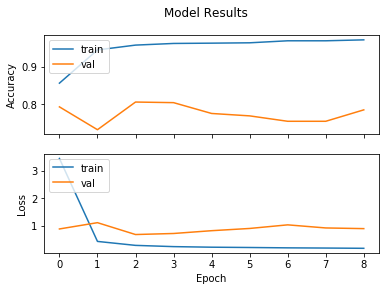

In [38]:
visualize_training_results(L1_reg_history)

In [40]:
L1 = load_model('best_L1.h5')
model_evaluation(L1)

163/163 [==============================] - 10s 60ms/step - loss: 0.2634 - accuracy: 0.9515
[0.26341795921325684, 0.9514954090118408]
1/1 [==============================] - 0s 141ms/step - loss: 0.2833 - accuracy: 1.0000
[0.28332796692848206, 1.0]


## L2 with padding

In [56]:
L2_padding = models.Sequential()
L2_padding.add(layers.Conv2D(32, (3, 3), kernel_regularizer=regularizers.l2(0.005), padding='same',
                             activation='relu', input_shape=(128,128,3)))
L2_padding.add(layers.MaxPooling2D((2, 2)))

L2_padding.add(layers.Conv2D(64, (3, 3), kernel_regularizer=regularizers.l2(0.005), padding='same',
                             activation='relu'))
L2_padding.add(layers.MaxPooling2D((2, 2)))

L2_padding.add(layers.Conv2D(128, (3, 3), kernel_regularizer=regularizers.l2(0.005), padding='same',
                             activation='relu'))
L2_padding.add(layers.MaxPooling2D((2, 2)))

L2_padding.add(layers.Flatten())
L2_padding.add(layers.Dense(128, activation='relu'))
L2_padding.add(layers.Dense(1, activation='sigmoid'))

L2_padding.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

In [57]:
es_L2_padding = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=6),
                 ModelCheckpoint(filepath='best_L2_padding.h5', monitor='val_accuracy', 
                                 mode='max', verbose=1, save_best_only=True)]

In [58]:
L2_padding_history = l2_padding.fit(X_train, y_train,
                                epochs=50,
                                batch_size=32,
                                callbacks=es_L2_padding,
                                validation_data=(X_test, y_test))

Epoch 1/50
163/163 [==============================] - 48s 292ms/step - loss: 0.8055 - accuracy: 0.8425 - val_loss: 1.2219 - val_accuracy: 0.7083

Epoch 00001: val_accuracy improved from -inf to 0.70833, saving model to best_l2_padding.h5
Epoch 2/50
163/163 [==============================] - 46s 283ms/step - loss: 0.2541 - accuracy: 0.9590 - val_loss: 1.4796 - val_accuracy: 0.7019

Epoch 00002: val_accuracy did not improve from 0.70833
Epoch 3/50
163/163 [==============================] - 45s 275ms/step - loss: 0.1788 - accuracy: 0.9658 - val_loss: 0.7072 - val_accuracy: 0.8109

Epoch 00003: val_accuracy improved from 0.70833 to 0.81090, saving model to best_l2_padding.h5
Epoch 4/50
163/163 [==============================] - 45s 276ms/step - loss: 0.1407 - accuracy: 0.9738 - val_loss: 0.9753 - val_accuracy: 0.7228

Epoch 00004: val_accuracy did not improve from 0.81090
Epoch 5/50
163/163 [==============================] - 46s 283ms/step - loss: 0.1187 - accuracy: 0.9795 - val_loss: 0.72

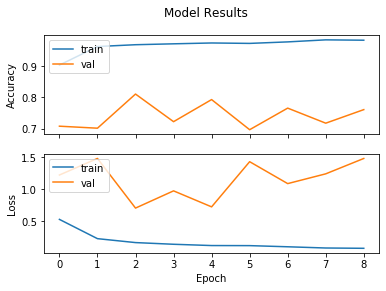

In [59]:
visualize_training_results(L2_padding_history)

In [60]:
L2_pad = load_model('best_L2_padding.h5')
model_evaluation(L2_pad)

163/163 [==============================] - 12s 70ms/step - loss: 0.1642 - accuracy: 0.9653
[0.1642114669084549, 0.9652990698814392]
1/1 [==============================] - 0s 144ms/step - loss: 0.2222 - accuracy: 0.9375
[0.22216513752937317, 0.9375]


## he_init

In [63]:
he_init = models.Sequential()
he_init.add(layers.Conv2D(32, (3, 3), kernel_initializer='he_normal', activation='relu', input_shape=(128,128,3)))
he_init.add(layers.MaxPooling2D((2, 2)))

he_init.add(layers.Conv2D(64, (3, 3), kernel_initializer='he_normal', activation='relu'))
he_init.add(layers.MaxPooling2D((2, 2)))

he_init.add(layers.Conv2D(128, (3, 3), kernel_initializer='he_normal', activation='relu'))
he_init.add(layers.MaxPooling2D((2, 2)))

he_init.add(layers.Flatten())
he_init.add(layers.Dense(128, activation='relu'))
he_init.add(layers.Dense(1, activation='sigmoid'))

he_init.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

In [64]:
es_he = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=6),
                    ModelCheckpoint(filepath='best_he.h5', monitor='val_accuracy', 
                                    mode='max', verbose=1, save_best_only=True)]

In [65]:
he_init_history = he_init.fit(X_train, y_train,
                                epochs=50,
                                batch_size=32,
                                callbacks=es_he,
                                validation_data=(X_test, y_test))

Epoch 1/50
163/163 [==============================] - 44s 270ms/step - loss: 0.8117 - accuracy: 0.8069 - val_loss: 1.0555 - val_accuracy: 0.7436

Epoch 00001: val_accuracy improved from -inf to 0.74359, saving model to best_he.h5
Epoch 2/50
163/163 [==============================] - 42s 259ms/step - loss: 0.0851 - accuracy: 0.9719 - val_loss: 0.9862 - val_accuracy: 0.7532

Epoch 00002: val_accuracy improved from 0.74359 to 0.75321, saving model to best_he.h5
Epoch 3/50
163/163 [==============================] - 42s 258ms/step - loss: 0.0741 - accuracy: 0.9723 - val_loss: 1.6548 - val_accuracy: 0.6987

Epoch 00003: val_accuracy did not improve from 0.75321
Epoch 4/50
163/163 [==============================] - 43s 261ms/step - loss: 0.0553 - accuracy: 0.9796 - val_loss: 1.0816 - val_accuracy: 0.7676

Epoch 00004: val_accuracy improved from 0.75321 to 0.76763, saving model to best_he.h5
Epoch 5/50
163/163 [==============================] - 43s 262ms/step - loss: 0.0421 - accuracy: 0.9824 

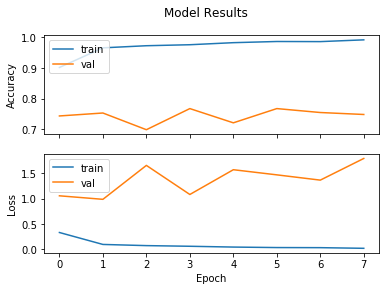

In [66]:
visualize_training_results(he_init_history)

In [67]:
he = load_model('best_he.h5')
model_evaluation(he)

163/163 [==============================] - 11s 64ms/step - loss: 0.0359 - accuracy: 0.9870
[0.035867590457201004, 0.9869632124900818]
1/1 [==============================] - 0s 141ms/step - loss: 0.0882 - accuracy: 1.0000
[0.08821989595890045, 1.0]


## Lecun_init

In [68]:
lecun_init = models.Sequential()
lecun_init.add(layers.Conv2D(32, (3, 3), kernel_initializer='lecun_normal', activation='relu', input_shape=(128,128,3)))
lecun_init.add(layers.MaxPooling2D((2, 2)))

lecun_init.add(layers.Conv2D(64, (3, 3), kernel_initializer='lecun_normal', activation='relu'))
lecun_init.add(layers.MaxPooling2D((2, 2)))

lecun_init.add(layers.Conv2D(128, (3, 3), kernel_initializer='lecun_normal', activation='relu'))
lecun_init.add(layers.MaxPooling2D((2, 2)))

lecun_init.add(layers.Flatten())
lecun_init.add(layers.Dense(128, activation='relu'))
lecun_init.add(layers.Dense(1, activation='sigmoid'))

lecun_init.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

In [69]:
es_lecun = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=6),
                    ModelCheckpoint(filepath='best_lecun.h5', monitor='val_accuracy', 
                                    mode='max', verbose=1, save_best_only=True)]

In [70]:
lecun_init_history = lecun_init.fit(X_train, y_train,
                                epochs=50,
                                batch_size=32,
                                callbacks=es_lecun,
                                validation_data=(X_test, y_test))

Epoch 1/50
163/163 [==============================] - 45s 273ms/step - loss: 0.5458 - accuracy: 0.8256 - val_loss: 0.5165 - val_accuracy: 0.7965

Epoch 00001: val_accuracy improved from -inf to 0.79647, saving model to best_lecun.h5
Epoch 2/50
163/163 [==============================] - 46s 280ms/step - loss: 0.1056 - accuracy: 0.9610 - val_loss: 0.6939 - val_accuracy: 0.7917

Epoch 00002: val_accuracy did not improve from 0.79647
Epoch 3/50
163/163 [==============================] - 42s 257ms/step - loss: 0.0740 - accuracy: 0.9693 - val_loss: 1.2661 - val_accuracy: 0.7676

Epoch 00003: val_accuracy did not improve from 0.79647
Epoch 4/50
163/163 [==============================] - 42s 255ms/step - loss: 0.0688 - accuracy: 0.9727 - val_loss: 0.9297 - val_accuracy: 0.7276

Epoch 00004: val_accuracy did not improve from 0.79647
Epoch 5/50
163/163 [==============================] - 42s 256ms/step - loss: 0.0737 - accuracy: 0.9747 - val_loss: 0.8173 - val_accuracy: 0.8077

Epoch 00005: val_a

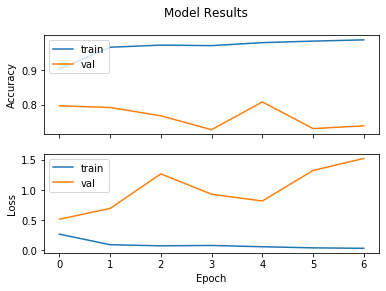

In [71]:
visualize_training_results(lecun_init_history)

In [72]:
lecun = load_model('best_lecun.h5')
model_evaluation(lecun)

163/163 [==============================] - 11s 65ms/step - loss: 0.0518 - accuracy: 0.9812
[0.05178162455558777, 0.9812116622924805]
1/1 [==============================] - 0s 129ms/step - loss: 0.1005 - accuracy: 0.9375
[0.10053324699401855, 0.9375]
